In [5]:
import numpy as np
import pandas as pd
import math
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [6]:
data=pd.read_csv('../input_data/Apparel/apparel-trainval.csv')

In [7]:
def standerdise(data):
    for i in data.columns:
        if i!='label':
            mean=data[i].mean()
            std=data[i].std()
            data[i]=(data[i]-mean)/std
    return data

In [8]:
data=standerdise(data)

In [139]:
train,validate = np.split(data,[int(.8*len(data))])

In [140]:
print np.shape(data)

(60000, 785)


In [222]:
def sigmoid(x):
    return 1/(1+np.exp(-x))
    
def tanh(x):
    return np.sinh(x)/np.cosh(x)

def Relu(x):
    return x * (x > 0)
    
def softmax(A):
    expA = np.exp(A)
    return (expA/expA.sum(axis=1,keepdims=True))

def sigmoid_der(x):
    return sigmoid(x) * (1- sigmoid(x))

def Relu_der(x):
    return 1. * (x > 0)
  
def tanh_der(x):
    t=(tanh(x)**2)
    return 1-t


In [142]:
label_col=train['label'].tolist()

In [143]:
one_hot_label=np.zeros((train.shape[0],10))

for i in range(train.shape[0]):
    one_hot_label[i,label_col[i]]=1
print one_hot_label

[[ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]]


In [144]:
def create_minibatches(batch_size,train):
    train_list=train.values
    rows=train.shape[0]

    ohl_list=one_hot_label.tolist()
    length=len(ohl_list)

    n = batch_size  #chunk row size batch size
    
    train_chunks = [train_list[i:i+n] for i in range(0,rows,n)]

    ohl_chunks = [ohl_list[i:i+n] for i in range(0,length,n)]

    return train_chunks,ohl_chunks

In [145]:
batch_size=raw_input("Enter Batch Size: ")
train = train.drop(columns=['label'])
train_chunks,ohl_chunks=create_minibatches(int(batch_size),train)

Enter Batch Size: 512


In [146]:
actual=[]
actual=validate['label'].tolist()
validate=validate.drop(columns=['label'])

In [147]:
learning_rate=raw_input("Enter Learning Rate: ")
learning_rate=float(learning_rate)

Enter Learning Rate: 0.0001


In [303]:
import pickle
class MultipleHiddenLayerNN:
    
    def __init__(self,input_size,output_size,hidden_size,num_of_hidden_layers):
        self.outputLayers=output_size
        self.inputLayers=input_size
        self.numHiddenLayers = num_of_hidden_layers
        self.hiddenLayers=hidden_size
        

        #list of weigths and biases of all the hidden layers
        #weight between i/p layer and hidden layer just next to i/p layer
        self.weights=[]
        
        weight1=np.random.randn(self.inputLayers,self.hiddenLayers)*math.sqrt(2.0/self.inputLayers)
#         print 'wwww',weight1.shape
        self.weights.append(weight1)
        
        
        self.biases=[]
        bias1=np.random.randn(hidden_size)
        self.biases.append(bias1)

        #for n-1 times we need to calculate the weights for itermediate hidden layers
        for i in range(self.numHiddenLayers-1):
            #assuming the size of each itermediate hidden layer to be the same
            self.weights.append(np.random.randn(self.hiddenLayers,self.hiddenLayers)*math.sqrt(2.0/self.hiddenLayers))
            self.biases.append(np.random.randn(hidden_size))

        #weight between the last hidden layer and the output layer
        self.weights.append(np.random.randn(self.hiddenLayers,self.outputLayers)*math.sqrt(2.0/self.hiddenLayers))
        self.biases.append(np.random.randn(output_size))

    def forwardPropagation(self,X,function):
        self.activation_list=[]
        self.training_matrix=X
#         print 'X',X.shape
#         print 'weight',self.weights[0].shape
        self.z2 = np.dot(X,self.weights[0])+self.biases[0]
#         print 'z2',self.z2.shape 
        self.a2 = function(self.z2)
        self.activation_list.append(self.a2)

        for i in range(self.numHiddenLayers-1):
            self.z2=np.dot(self.activation_list[i],self.weights[i+1])+self.biases[i+1]
            self.a2=function(self.z2)
            self.activation_list.append(self.a2)

        self.z3=np.dot(self.activation_list[self.numHiddenLayers-1],self.weights[self.numHiddenLayers])+self.biases[self.numHiddenLayers]
        
        yHat =softmax(self.z3)

        return yHat

    def backPropagation(self, yHat, yactual, function_der,learning_rate):

        derivative_wgt=[]
        derivative_bias=[]
        cost = yHat - yactual
        #propagating backwards from last layer to first
        for l in range(self.numHiddenLayers,0,-1):
            dz3_dw = self.activation_list[l-1]
            
            wgt_der=np.dot(dz3_dw.T,cost)
            bs_der=np.average(cost,axis=0)
            
            derivative_wgt.append(wgt_der)

            derivative_bias.append(bs_der)
            
            cost=np.dot(cost,self.weights[l].T)

        cost*=function_der(dz3_dw)#derivative of function(sigmoid or tanh)

        derivative_wgt.append(learning_rate*np.dot(self.training_matrix.T,cost))

        derivative_wgt=derivative_wgt[::-1]
        
        derivative_bias.append(learning_rate*np.average(cost,axis=0))
    
        derivative_bias=derivative_bias[::-1]

        return derivative_wgt,derivative_bias


    def updateWeight(self,wgt,bias,learning_rate):
        for l in range(self.numHiddenLayers + 1):
            self.weights[l]-=learning_rate * wgt[l]
            self.biases[l]-=learning_rate * bias[l].sum(axis=0)

    def calculate_loss(self,yHat,yactual):
        loss=np.sum(-yactual * np.log(yHat))
        return loss
    
    def saveWeights(self):
        with open('weights.txt','wb') as fp:
            pickle.dump(self.weights,fp)
        with open('biases.txt','wb') as fp:
            pickle.dump(self.biases,fp)
            
    

In [284]:
input_size=raw_input("Enter input size: ")
output_size=raw_input("Enter output size: ")
hidden_size=raw_input("Enter hidden layer size: ")
num=raw_input("Enter number of hidden layers: ")

Enter input size: 784
Enter output size: 10
Enter hidden layer size: 38
Enter number of hidden layers: 1


In [285]:
multiNNTanh=MultipleHiddenLayerNN(int(input_size),int(output_size),int(hidden_size),int(num))
multiNNSig=MultipleHiddenLayerNN(int(input_size),int(output_size),int(hidden_size),int(num))
multiNNRelu=MultipleHiddenLayerNN(int(input_size),int(output_size),int(hidden_size),int(num))

In [286]:
def create_error_list(function,multiNN,train_chunks,ohl_chunks,function_der,learning_rate):
    x_list_multi=[]
    error_list_multi=[]

    for i in range(5):
        predicted=np.array([])
        actual_t=np.array([])
        for j in range(len(train_chunks)):
            yHat=multiNN.forwardPropagation(train_chunks[j],function)
            der_wgt,der_bias=multiNN.backPropagation(yHat, ohl_chunks[j], function_der,10e-4)
            multiNN.updateWeight(der_wgt,der_bias,learning_rate)
            predicted=np.vstack([predicted,yHat]) if predicted.size else yHat
            actual_t=np.vstack([actual_t,ohl_chunks[j]]) if len(actual_t) else ohl_chunks[j]

        if i%1==0:
            x_list_multi.append(i)
            loss = multiNN.calculate_loss(predicted,actual_t)
            print "Loss function value: ", loss
            error_list_multi.append(loss)
            print 
    return x_list_multi,error_list_multi

In [287]:
print "-----------------------------------Tanh---------------------------"
x_tanh,error_tanh=create_error_list(tanh,multiNNTanh,train_chunks,ohl_chunks,tanh_der,learning_rate)

print "---------------------------------sigmoid--------------------------"
x_sig,error_sig=create_error_list(sigmoid,multiNNSig,train_chunks,ohl_chunks,sigmoid_der,learning_rate)

print "----------------------------------Relu-----------------------------"
x_relu,error_relu=create_error_list(Relu,multiNNRelu,train_chunks,ohl_chunks,Relu_der,learning_rate)

-----------------------------------Tanh---------------------------
Loss function value:  89987.3095799

Loss function value:  60485.2450533

Loss function value:  51906.9822288

Loss function value:  47569.3156789

Loss function value:  44878.4451643

---------------------------------sigmoid--------------------------
Loss function value:  107445.615248

Loss function value:  90877.0572398

Loss function value:  81726.7663805

Loss function value:  75071.0446992

Loss function value:  70026.4816458

----------------------------------Relu-----------------------------
Loss function value:  94590.0923527

Loss function value:  61725.2895007

Loss function value:  54340.4874642

Loss function value:  50698.545676

Loss function value:  48362.5272745



In [288]:
def create_graph(x_list,error_list,name):
    plt.figure(figsize=(5,5))
    plt.title(name)
    plt.plot(x_list,error_list)


In [289]:
def calculate_accuracy(multiNN,validate,function,actual):
#     print 'shape',np.shape(validate)
    yHat_validate_multi = multiNN.forwardPropagation(validate,function)
    validate_pred=[]
#     print 'yhat',np.shape(yHat_validate_multi)
    for i in yHat_validate_multi:
        validate_pred.append(i.argmax())  
    
    accu=accuracy_score(actual,validate_pred)*100
    return validate_pred,accu

In [290]:
# create_graph(x_tanh,error_tanh,"iteration v/s error for Tanh")
validate_pred_tanh,accu_tanh=calculate_accuracy(multiNNTanh,validate,tanh,actual)
print "Accuracy: ",accu_tanh

Accuracy:  69.9416666667


In [291]:
# create_graph(x_sig,error_sig,"iteration v/s error for Sigmoid")
validate_pred_sig,accu_sig=calculate_accuracy(multiNNSig,validate,sigmoid,actual)
print "Accuracy: ",accu_sig

Accuracy:  61.175


In [292]:
# create_graph(x_relu,error_relu,"iteration v/s error for Relu")
validate_pred_relu,accu_relu=calculate_accuracy(multiNNRelu,validate,Relu,actual)
print "Accuracy: ",accu_relu

Accuracy:  67.175


Text(0.5,1,'loss vs iterations')

<Figure size 360x360 with 0 Axes>

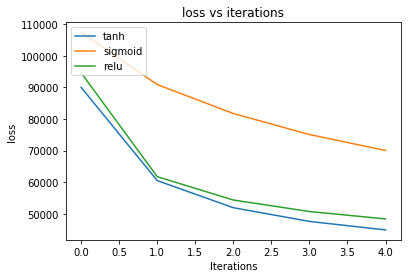

In [293]:
plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
plt.title("Iterations v/s prediction loss")
ax.plot(x_tanh,error_tanh,label="tanh")
ax.plot(x_sig,error_sig,label="sigmoid")
ax.plot(x_relu,error_relu,label="relu")
ax.legend(loc=2)
ax.set_xlabel('Iterations')
ax.set_ylabel('loss')
ax.set_title('loss vs iterations')

In [294]:
multiNNTanh.saveWeights()

In [295]:
def create_error_list_for_layer(function,multiNN,train_chunks,ohl_chunks,function_der,learning_rate):
    error_list_multi=[]

    for i in range(5):
        predicted=np.array([])
        actual_t=np.array([])
        for j in range(len(train_chunks)):
            yHat=multiNN.forwardPropagation(train_chunks[j],function)
            der_wgt,der_bias=multiNN.backPropagation(yHat, ohl_chunks[j], function_der,10e-4)
            multiNN.updateWeight(der_wgt,der_bias,learning_rate)
            predicted=np.vstack([predicted,yHat]) if predicted.size else yHat
            actual_t=np.vstack([actual_t,ohl_chunks[j]]) if len(actual_t) else ohl_chunks[j]

        if i%1==0:
            loss = multiNN.calculate_loss(predicted,actual_t)
            error_list_multi.append(loss)

    return error_list_multi

In [296]:
def layers_vs_error(function,function_der,train_chunks,ohl_chunks,learning_rate,validate,actual):
    layers=[]
    errors=[]
    
    multiNN1=MultipleHiddenLayerNN(int(input_size),int(output_size),int(hidden_size),1)
    error_list1=create_error_list_for_layer(function,multiNN1,train_chunks,ohl_chunks,function_der,learning_rate)
    errors.append(error_list1[-1])
    layers.append(1)
    
    print "for 1 layer"
    calculate_accuracy(multiNN1,validate,function,actual)
    
    multiNN2=MultipleHiddenLayerNN(int(input_size),int(output_size),int(hidden_size),2)
    error_list2=create_error_list_for_layer(function,multiNN2,train_chunks,ohl_chunks,function_der,learning_rate)
    errors.append(error_list2[-1])
    layers.append(2)
    
    print "for 2 layer"
    calculate_accuracy(multiNN2,validate,function,actual)
    
    multiNN3=MultipleHiddenLayerNN(int(input_size),int(output_size),int(hidden_size),3)
    error_list3=create_error_list_for_layer(function,multiNN3,train_chunks,ohl_chunks,function_der,learning_rate)
    errors.append(error_list3[-1])
    layers.append(3)
    
    print "for 3 layer"
    calculate_accuracy(multiNN3,validate,function,actual)
    
    multiNN4=MultipleHiddenLayerNN(int(input_size),int(output_size),int(hidden_size),4)
    error_list4=create_error_list_for_layer(function,multiNN4,train_chunks,ohl_chunks,function_der,learning_rate)
    errors.append(error_list4[-1])
    layers.append(4)
    
    print "for 4 layer"
    calculate_accuracy(multiNN4,validate,function,actual)
    
    multiNN5=MultipleHiddenLayerNN(int(input_size),int(output_size),int(hidden_size),5)
    error_list5=create_error_list_for_layer(function,multiNN5,train_chunks,ohl_chunks,function_der,learning_rate)
    errors.append(error_list5[-1])
    layers.append(5)
    
    print "for 5 layer"
    calculate_accuracy(multiNN5,validate,function,actual)
    
    return layers,errors

In [297]:
layers_tanh,errors_tanh=layers_vs_error(tanh,tanh_der,train_chunks,ohl_chunks,0.001,validate,actual)
# create_graph(layers_tanh,errors_tanh,"layers v/s error for tanh")

for 1 layer
for 2 layer
for 3 layer
for 4 layer


/home/prabha/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in sinh
  """
/home/prabha/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in cosh
  """
/home/prabha/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in divide
  """


for 5 layer


In [298]:
layers_sig,errors_sig=layers_vs_error(sigmoid,sigmoid_der,train_chunks,ohl_chunks,0.001,validate,actual)
# create_graph(layers_sig,errors_sig,"layers v/s error for sigmoid")

for 1 layer
for 2 layer
for 3 layer


/home/prabha/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


for 4 layer
for 5 layer


In [299]:
layers_relu,errors_relu=layers_vs_error(Relu,Relu_der,train_chunks,ohl_chunks,0.001,validate,actual)
# print "0.001"
# create_graph(layers_relu,errors_relu,"layers v/s error for Relu")

for 1 layer
for 2 layer


/home/prabha/.local/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
/home/prabha/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in divide
  if sys.path[0] == '':
/home/prabha/.local/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/prabha/.local/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/home/prabha/.local/lib/python2.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in log
/home/prabha/.local/lib/python2.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in multiply


for 3 layer
for 4 layer
for 5 layer


Text(0.5,1,'loss vs layer')

<Figure size 360x360 with 0 Axes>

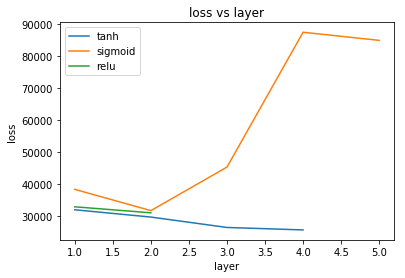

In [300]:
plt.figure(figsize=(5,5))
fig, ax = plt.subplots()
plt.title("Layers v/s prediction loss")
ax.plot(layers_tanh,errors_tanh,label="tanh")
ax.plot(layers_sig,errors_sig,label="sigmoid")
ax.plot(layers_relu,errors_relu,label="relu")
ax.legend(loc=2)
ax.set_xlabel('layer')
ax.set_ylabel('loss')
ax.set_title('loss vs layer')

In [301]:
def pred(multiNN,validate,function):
#     print 'shape',np.shape(validate)
    yHat_validate_multi = multiNN.forwardPropagation(validate,function)
    validate_pred=[]
#     print 'yhat',np.shape(yHat_validate_multi)
    for i in yHat_validate_multi:
        validate_pred.append(i.argmax()) 
    return validate_pred
    

In [302]:
test_file=pd.read_csv('../input_data/Apparel/apparel-trainval.csv')
print len(test_file)
import csv
def predict(test_file,input_size,output_size,hidden_size,layer,function):
    wgt_file = []
    bias_file = []
    with open('weights.txt','rb') as fp:
        wgt_file = pickle.load(fp)
    with open('biases.txt','rb') as fp:
        bias_file = pickle.load(fp)
    multiNN=MultipleHiddenLayerNN(int(input_size),int(output_size),int(hidden_size),layer)
    multiNN.weights=wgt_file
    multiNN.biases=bias_file
    validate_pred=pred(multiNN,test_file,function)
    
    return validate_pred

pred= predict(test_file,input_size,output_size,hidden_size,1,tanh)
print pred
with open('2018201053_prediction.csv', 'wb') as f:
    wr = csv.writer(f, delimiter='\n')
    wr.writerow(pred)

9674
[6, 3, 2, 0, 3, 6, 8, 6, 9, 0, 3, 2, 6, 6, 9, 0, 6, 3, 6, 6, 4, 4, 2, 3, 4, 9, 4, 4, 4, 3, 9, 9, 9, 8, 6, 0, 9, 4, 4, 9, 2, 0, 4, 4, 0, 4, 3, 4, 2, 3, 4, 6, 9, 3, 4, 9, 9, 4, 0, 3, 4, 9, 2, 6, 3, 1, 0, 9, 8, 2, 7, 1, 4, 6, 9, 7, 3, 4, 4, 3, 9, 0, 3, 2, 4, 8, 9, 2, 3, 2, 3, 6, 6, 2, 2, 3, 4, 8, 9, 3, 9, 3, 9, 4, 0, 2, 3, 0, 6, 7, 8, 7, 3, 4, 7, 8, 4, 0, 7, 4, 4, 9, 4, 6, 7, 0, 9, 9, 6, 3, 4, 7, 9, 3, 9, 6, 2, 2, 4, 4, 3, 3, 0, 4, 2, 2, 3, 4, 3, 3, 4, 3, 3, 3, 9, 6, 6, 3, 9, 9, 4, 7, 8, 1, 6, 4, 6, 6, 7, 2, 6, 6, 9, 4, 6, 4, 6, 9, 9, 9, 9, 3, 3, 9, 4, 8, 9, 6, 4, 7, 3, 9, 3, 6, 2, 2, 2, 4, 6, 9, 6, 6, 2, 4, 9, 4, 6, 4, 4, 9, 6, 4, 7, 1, 8, 9, 9, 2, 2, 8, 7, 9, 9, 4, 2, 4, 8, 9, 9, 3, 9, 2, 8, 0, 9, 7, 4, 0, 9, 2, 3, 7, 9, 7, 0, 6, 4, 2, 3, 3, 8, 3, 4, 2, 6, 2, 3, 9, 0, 3, 3, 6, 2, 6, 4, 9, 3, 9, 4, 9, 6, 6, 4, 6, 8, 4, 7, 7, 9, 7, 9, 0, 2, 8, 3, 8, 3, 3, 2, 2, 2, 1, 8, 3, 3, 3, 3, 4, 9, 2, 4, 4, 4, 9, 0, 4, 7, 4, 7, 9, 1, 4, 6, 4, 7, 9, 8, 0, 9, 2, 4, 2, 8, 3, 9, 2, 4, 7, 7, 2, 4, 2

/home/prabha/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in sinh
  """
/home/prabha/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in cosh
  """
/home/prabha/.local/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in divide
  """
